# Inferring material properties of a cantilevered beam

Recall the beam from last week. Previously, we fixed the material properties and inferred the applied load.  Here we flip the problem, the loads will be fixed and we will infer the material properties.


### Formulation:

Again, let $u(x)$ denote the vertical deflection of the beam and let $m(x)$ denote the vertial force acting on the beam at point $x$ (positive for upwards, negative for downwards).  We assume that the displacement can be well approximated using Euler-Bernoulli beam theory and thus satisfies the PDE
$$
\frac{\partial^2}{\partial x^2}\left[ E(x) \frac{\partial^2 u}{\partial x^2}\right] = m(x),
$$
where $E(x)$ is an effective stiffness that depends both on the beam geometry and material properties.  Our goal is to infer $E(x)$ given observations of $u(x)$ and a known load $m(x)$.

The same cantilever boundary conditions are used as before.  These take the form
$$
u(x=0) = 0,\quad \left.\frac{\partial u}{\partial x}\right|_{x=0} = 0
$$
and
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x=L} = 0, \quad  \left.\frac{\partial^3 u}{\partial x^3}\right|_{x=L} = 0.
$$


We assume that $E(x)$ is piecwise constant over $P$ nonoverlapping intervals on $[0,L]$.  More precisely,
$$
E(x) = \sum_{i=1}^P e_i \,I\left(x\in [a_i, a_{i+1})\right),
$$
where $I(\cdot)$ is an indicator function.  We assume each value is an independent lognormal random variable
$$
\log(e_i) \sim N(\mu_i, \sigma_i^2).
$$

In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
matplotlib.rcParams['font.size'] = 16

import pandas as pd

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import h5py

from BeamModel import EulerBernoulli

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC


In [2]:
f = h5py.File('ProblemDefinition.h5','r')

x = np.array( f['/ForwardModel/NodeLocations'] )
B = np.array( f['/Observations/ObservationMatrix'] )
obsData = np.array( f['/Observations/ObservationData'] )

length = f['/ForwardModel'].attrs['BeamLength']
radius = f['/ForwardModel'].attrs['BeamRadius']

loads = np.array( f['/ForwardModel/Loads'])

numObs = obsData.shape[0]
numPts = x.shape[1]
dim = 1


In [3]:
numInts = 3
endPts = np.linspace(0,1,numInts+1)
ints = [(endPts[i],endPts[i+1]) for i in range(numInts)]

## Define the prior

In [4]:
logPriorMu = 10*np.ones(numInts)
logPriorCov = 4.0*np.eye(numInts)

logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()


## Define the forward model

In [5]:
class LumpedToFull(mm.PyModPiece):
    
    def __init__(self, intervals, pts):
        """ 
        INPUTS:
          - Intervals is a list of tuples containing the intervals that define the 
            modulus field. 
          - pts is a vector containing the locations of the finite difference nodes
        """
        mm.PyModPiece.__init__(self, [len(intervals)], # One input containing lumped params
                                     [pts.shape[1]]) # One output containing the full E field
        
        # build a vector of indices mapping an index in the full vector to a continuous parameter
        self.vec2lump = np.zeros(pts.shape[1], dtype=np.uint)
        for i in range(len(intervals)):
            self.vec2lump[ (pts[0,:]>=intervals[i][0]) & (pts[0,:]<intervals[i][1]) ] = i
            
            
    def EvaluateImpl(self, inputs):
    
        self.outputs = [ inputs[0][self.vec2lump] ]

In [6]:
modulusField = LumpedToFull(ints, x )
modulusVals = mm.ExpOperator(numInts)

## Likelihood function

In [7]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

## Posterior

In [8]:
beam = EulerBernoulli(numPts, length, radius)

graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(beam,"Forward Model")
graph.AddNode(mm.IdentityOperator(numInts), "Log Modulus")
graph.AddNode(mm.ExpOperator(numInts), "Modulus")
lumpToFull = LumpedToFull(ints,x)
graph.AddNode(lumpToFull, "Modulus Field")
graph.AddNode(mm.ConstantVector(loads), "Load")
graph.AddNode(mm.DenseLinearOperator(B), "Observation Matrix")

graph.AddEdge("Log Modulus", 0, "Modulus", 0)
graph.AddEdge("Modulus", 0, "Modulus Field", 0)
graph.AddEdge("Modulus Field", 0, "Forward Model", 1)
graph.AddEdge("Load", 0, "Forward Model", 0)
graph.AddEdge("Forward Model", 0, "Observation Matrix", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(mm.DensityProduct(2),"Posterior")

graph.AddEdge("Observation Matrix", 0, "Likelihood", 0)
graph.AddEdge("Log Modulus", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

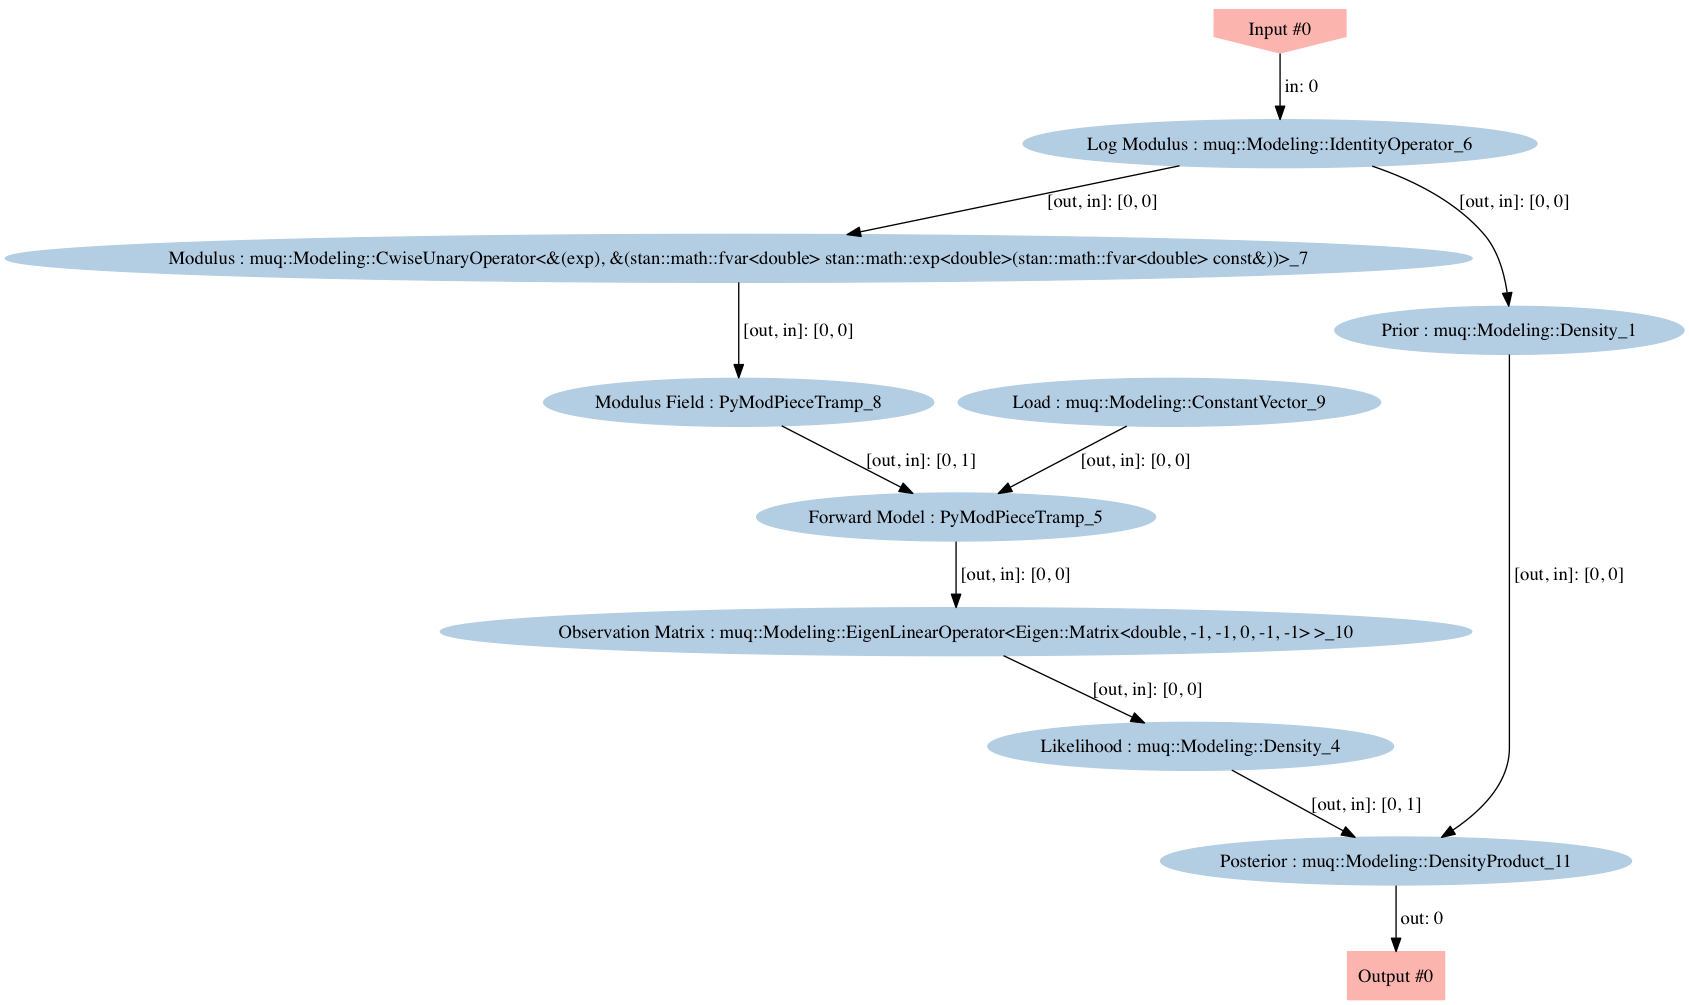

In [9]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [10]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [11]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-2
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 50000
options['ThinIncrement'] = 1
options['BurnIn'] = 10000
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [12]:
startPt = 10.0*np.ones(numInts)
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 16%
  20% Complete
    Block 0:
      Acceptance Rate = 21%
  30% Complete
    Block 0:
      Acceptance Rate = 24%
  40% Complete
    Block 0:
      Acceptance Rate = 26%
  50% Complete
    Block 0:
      Acceptance Rate = 26%
  60% Complete
    Block 0:
      Acceptance Rate = 27%
  70% Complete
    Block 0:
      Acceptance Rate = 28%
  80% Complete
    Block 0:
      Acceptance Rate = 29%
  90% Complete
    Block 0:
      Acceptance Rate = 29%
  100% Complete
    Block 0:
      Acceptance Rate = 29%
Completed in 10.5285 seconds.


In [13]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

Effective Sample Size = 
 [ 100.53210376   84.64567765   98.73206482]

Sample mean = 
 [ 9.2775832   9.28031238  9.20454822]

Sample Covariance = 
 [[  1.63704507e-03   1.35786904e-03   5.34041228e-05]
 [  1.35786904e-03   1.56582759e-03   3.24480496e-04]
 [  5.34041228e-05   3.24480496e-04   4.62149513e-03]]

Estimated MC error in mean = 
 [ 0.00403532  0.004301    0.00684167]


In [14]:
sampMat = samps.AsMatrix()

## Plot the posterior samples

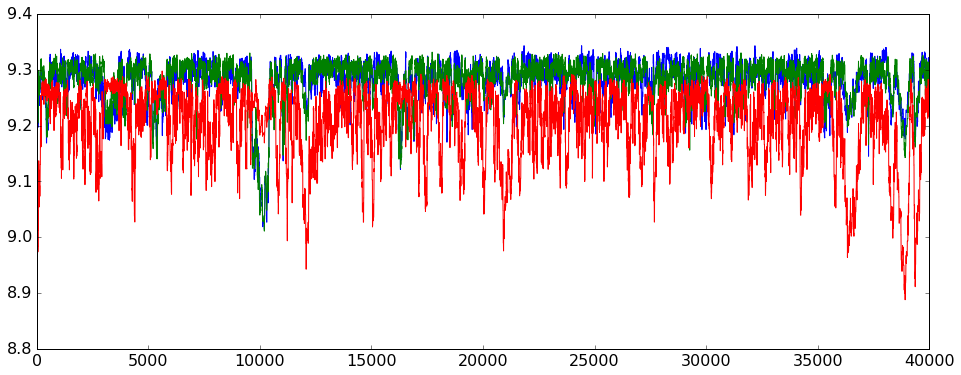

In [15]:
plt.plot(sampMat.T)
plt.show()

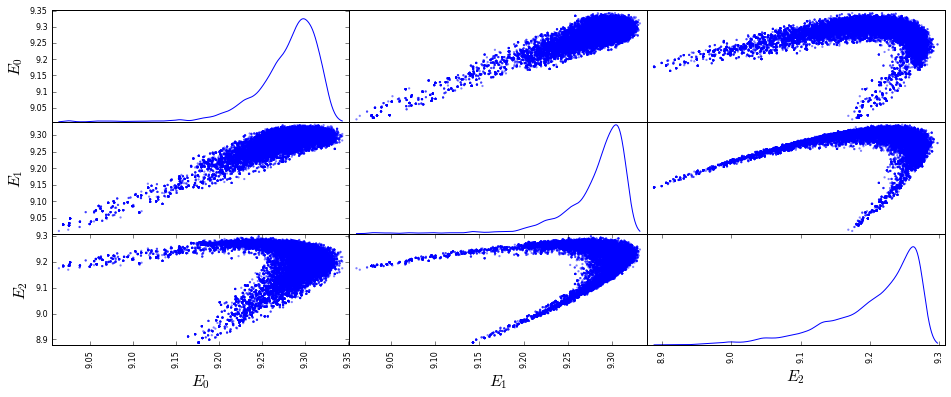

In [16]:
plt.figure(figsize=(12,12))
df = pd.DataFrame(sampMat.T, columns=['$E_%d$'%i for i in range(numInts) ])

pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.5)
plt.show()

## Plot samples of the posterior predictive

In [17]:
predSamps = np.zeros((numPts, sampMat.shape[1]))

predModel = graph.CreateModPiece("Forward Model")

for i in range(sampMat.shape[1]):
    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]
    

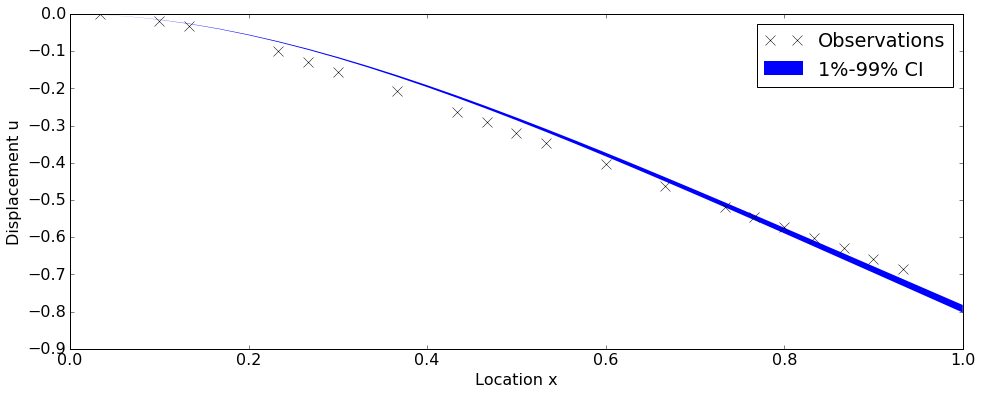

In [18]:
# Plot quantiles
plt.fill_between(x[0,:], 
                 np.percentile(predSamps,1,axis=1),
                 np.percentile(predSamps,99,axis=1),
                 edgecolor='none', label='1%-99% CI')

# Plot the observations
obsInds = np.where(B>0)[1]
plt.plot(x[0,obsInds], obsData, 'xk', markerSize=10, label='Observations')

plt.legend()
plt.xlabel('Location x')
plt.ylabel('Displacement u')
plt.show()